X–θ test on NIST processed_compressed build.hdf5

We define a candidate hidden phase θ (either from settings-holonomy or from a trial clock), bin trials by θ, compute an Eberhard-style J per bin, and use a drift-preserving permutation test to see if modulation is real or an artifact.


In [44]:
import os, math, json
from dataclasses import dataclass
from typing import Dict, Any, Tuple

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
@dataclass
class CFG:
    URL: str = (
        "https://s3.amazonaws.com/nist-belltestdata/belldata/processed_compressed/hdf5/2015_09_18/"
        "02_54_CH_pockel_100kHz.run4.afterTimingfix2.dat.compressed.build.hdf5"
    )

    # https://s3.amazonaws.com/nist-belltestdata/belldata/processed_compressed/hdf5/2015_09_18/
    # "03_31_CH_pockel_100kHz.run4.afterTimingfix2_training.dat.compressed.build.hdf5"

    HDF5_PATH: str = "./data_nist/nist_run.build.hdf5"

    START: int = 0
    MAX_TRIALS: int = 3_000_000  # None for full file (heavy)

    # theta modes:
    # 1) "turning_angle_settings_path" = holonomy of settings-history (global memory hypothesis)
    # 2) "index_phase" = theta_n = 2π (n mod P)/P  (per-trial clock hypothesis)
    THETA_MODE: str = "turning_angle_settings_path"
    PERIOD_P: int = 4096  # used only for index_phase

    THETA_BINS: int = 12
    THETA_WRAP_2PI: bool = True

    BLOCK_SIZE: int = 20_000
    PERM_ROUNDS: int = 200
    SEED: int = 123

    MIN_VALID_PER_BIN: int = 20_000


CFG = CFG()
CFG.THETA_BINS = 4
CFG.MIN_VALID_PER_BIN = 100
CFG.MAX_TRIALS = None


os.makedirs(os.path.dirname(CFG.HDF5_PATH), exist_ok=True)
print("Using HDF5_PATH:", CFG.HDF5_PATH)


def download_with_resume(url: str, out_path: str, chunk_size: int = 8 * 1024 * 1024):
    import requests

    headers = {}
    mode = "wb"
    if os.path.exists(out_path):
        existing = os.path.getsize(out_path)
        headers["Range"] = f"bytes={existing}-"
        mode = "ab"
        print(f"Resuming at byte {existing:,}")
    else:
        print("Starting fresh download")

    with requests.get(url, stream=True, headers=headers, timeout=60) as r:
        r.raise_for_status()
        with open(out_path, mode) as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)


if not os.path.exists(CFG.HDF5_PATH):
    download_with_resume(CFG.URL, CFG.HDF5_PATH)
else:
    print("File exists, skipping download.")

Using HDF5_PATH: ./data_nist/nist_run.build.hdf5
File exists, skipping download.


In [46]:
# Check if the required datasets exist
with h5py.File(CFG.HDF5_PATH, "r") as h5:
    required_datasets = [
        "alice/clicks",
        "bob/clicks",
        "alice/settings",
        "bob/settings",
        "offsets/firstsync/alice",
        "offsets/firstsync/bob",
    ]
    missing = [ds for ds in required_datasets if ds not in h5]
    if missing:
        print(f"Missing datasets: {missing}")
    else:
        print("All required datasets are present.")

All required datasets are present.


In [47]:
with h5py.File(CFG.HDF5_PATH, "r") as h5:
    print("Has offsets group?", "offsets" in h5)
    if "offsets" in h5:
        print("offsets keys:", list(h5["offsets"].keys()))
    print("Has syncNumber?", "alice/syncNumber" in h5, "bob/syncNumber" in h5)
    print("Has badSyncInfo?", "alice/badSyncInfo" in h5, "bob/badSyncInfo" in h5)

Has offsets group? True
offsets keys: ['firstsync', 'lastidx']
Has syncNumber? True True
Has badSyncInfo? True True


settings are often stored as {1,2}. We remap the two most common values → {0,1}.


In [48]:
def remap_two_state_to_01(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    vals, cnt = np.unique(x, return_counts=True)
    order = np.argsort(cnt)[::-1]
    if len(order) < 2:
        return np.full_like(x, -1, dtype=np.int8)
    v0, v1 = vals[order[0]], vals[order[1]]
    out = np.full(x.shape, -1, dtype=np.int8)
    out[x == v0] = 0
    out[x == v1] = 1
    return out


def load_raw_arrays(hdf5_path: str):
    with h5py.File(hdf5_path, "r") as h5:
        a_set_raw = h5["alice/settings"][:]
        b_set_raw = h5["bob/settings"][:]
        a_click = h5["alice/clicks"][:].astype(np.uint16)
        b_click = h5["bob/clicks"][:].astype(np.uint16)
    a_set = remap_two_state_to_01(a_set_raw).astype(np.int8)
    b_set = remap_two_state_to_01(b_set_raw).astype(np.int8)
    return a_set, b_set, a_click, b_click


a_set_full, b_set_full, a_click_full, b_click_full = load_raw_arrays(CFG.HDF5_PATH)
print("lens:", len(a_set_full), len(b_set_full), len(a_click_full), len(b_click_full))
print(
    "click nonzero frac:",
    float((a_click_full != 0).mean()),
    float((b_click_full != 0).mean()),
)


if len(a_click_full) < 1_000_000 or len(b_click_full) < 1_000_000:
    raise RuntimeError(
        "This HDF5 file contains only stub click data "
        f"(alice={len(a_click_full)}, bob={len(b_click_full)}). "
        "Switch CFG.URL to a real experimental run."
    )

lens: 213469615 213469608 203681462 203681462
click nonzero frac: 0.0013211560706491788 0.0014034757861272618


Offset scoring function

We score an offset by how strongly click rate differs by settings.
If settings are misaligned, click rate vs setting will wash out.


In [49]:
def score_offset_click_dependence(
    settings: np.ndarray, clicks: np.ndarray, offset: int, N: int
) -> float:
    """
    Higher is better.
    Score = sum over setting values of |p(click|setting) - p(click)| weighted by count.
    """
    s = settings[offset : offset + N]
    if len(s) < N:
        return -np.inf
    ok = s >= 0
    s = s[ok]
    c = (clicks[: len(ok)][ok] != 0).astype(np.int8)
    if len(s) < 1000:
        return -np.inf

    p0 = float(c.mean())
    score = 0.0
    for val in (0, 1):
        m = s == val
        if m.sum() < 1000:
            continue
        pv = float(c[m].mean())
        score += float(m.sum()) * abs(pv - p0)
    return score


def scan_best_offset(
    settings: np.ndarray,
    clicks: np.ndarray,
    search_center: int,
    search_halfwidth: int,
    step: int,
    N_train: int,
) -> Dict[str, Any]:
    best = {"offset": None, "score": -np.inf}
    for off in range(
        max(0, search_center - search_halfwidth),
        min(len(settings) - N_train, search_center + search_halfwidth) + 1,
        step,
    ):
        sc = score_offset_click_dependence(settings, clicks, off, N_train)
        if sc > best["score"]:
            best = {"offset": off, "score": sc}
    return best


# ---- Choose TRAIN length & scan window ----
N_train = 2_000_000

# heuristic: clicks are shorter, so start search near where the overlap could begin
# If settings are longer by D, the offset is likely in [0..D]
D_a = len(a_set_full) - len(a_click_full)
D_b = len(b_set_full) - len(b_click_full)
print("D_a, D_b:", D_a, D_b)

# Scan a coarse grid first
best_a_coarse = scan_best_offset(
    a_set_full,
    a_click_full,
    search_center=D_a // 2,
    search_halfwidth=D_a // 2,
    step=200_000,
    N_train=N_train,
)
best_b_coarse = scan_best_offset(
    b_set_full,
    b_click_full,
    search_center=D_b // 2,
    search_halfwidth=D_b // 2,
    step=200_000,
    N_train=N_train,
)

print("best_a_coarse:", best_a_coarse)
print("best_b_coarse:", best_b_coarse)

# Refine around the coarse winners
best_a = scan_best_offset(
    a_set_full,
    a_click_full,
    search_center=best_a_coarse["offset"],
    search_halfwidth=500_000,
    step=20_000,
    N_train=N_train,
)
best_b = scan_best_offset(
    b_set_full,
    b_click_full,
    search_center=best_b_coarse["offset"],
    search_halfwidth=500_000,
    step=20_000,
    N_train=N_train,
)

print("best_a_refined:", best_a)
print("best_b_refined:", best_b)

D_a, D_b: 9788153 9788146
best_a_coarse: {'offset': 0, 'score': 1423.275486}
best_b_coarse: {'offset': 0, 'score': 1550.22608}
best_a_refined: {'offset': 0, 'score': 1423.275486}
best_b_refined: {'offset': 0, 'score': 1550.22608}


Offset scoring function

We score an offset by how strongly click rate differs by settings.
If settings are misaligned, click rate vs setting will wash out.


In [ ]:
def build_aligned_slice(
    a_set_full,
    b_set_full,
    a_click_full,
    b_click_full,
    off_a: int,
    off_b: int,
    start_click: int,
    N: int,
):
    """
    click index range [start_click : start_click+N] aligns to
    a_set_full[off_a+start_click : off_a+start_click+N]
    b_set_full[off_b+start_click : off_b+start_click+N]
    """
    end = start_click + N
    a_click = a_click_full[start_click:end]
    b_click = b_click_full[start_click:end]
    a_set = a_set_full[off_a + start_click : off_a + end]
    b_set = b_set_full[off_b + start_click : off_b + end]

    # keep only valid settings
    ok = (a_set >= 0) & (b_set >= 0)
    return a_set[ok], b_set[ok], a_click[ok], b_click[ok]


# choose TEST slice after training region (avoid leakage)
start_click_test = N_train + 200_000
N_test = CFG.MAX_TRIALS if CFG.MAX_TRIALS is not None else 3_000_000

a_set, b_set, a_click, b_click = build_aligned_slice(
    a_set_full,
    b_set_full,
    a_click_full,
    b_click_full,
    off_a=best_a["offset"],
    off_b=best_b["offset"],
    start_click=start_click_test,
    N=N_test,
)

print("TEST N:", len(a_set))
print("click nonzero frac:", float((a_click != 0).mean()), float((b_click != 0).mean()))

TEST N: 3000000
click nonzero frac: 0.00134 0.001407


## θ from click-slot phase difference (per-coincidence)

Define θ from the relative arrival phase of Alice and Bob clicks within
the 16-slot Pockels-cell timing cycle.
Only coincidence trials are used.


In [ ]:
def decode_slot_from_click(mask: np.ndarray) -> np.ndarray:
    """
    mask: uint16 click mask
    returns slot index in [0..15], or -1 if no click
    """
    slot = np.full(len(mask), -1, dtype=np.int8)
    nz = mask != 0
    # mask has at most one bit set (you verified this)
    slot[nz] = np.log2(mask[nz]).astype(np.int8)
    return slot


slotA = decode_slot_from_click(a_click)
slotB = decode_slot_from_click(b_click)

print("slotA range:", slotA.min(), slotA.max())
print("slotB range:", slotB.min(), slotB.max())

slotA range: -1 15
slotB range: -1 15


## Build coincidence set and θ values


In [ ]:
# coincidence mask
coin = (slotA >= 0) & (slotB >= 0)

print("Coincidences:", int(coin.sum()), "out of", len(slotA))

# θ = phase difference on a 16-cycle
theta = (2 * np.pi / 16.0) * ((slotA[coin] - slotB[coin]) % 16)

# outcomes for coincidence trials
A_det = np.ones(len(theta), dtype=np.int8)
B_det = np.ones(len(theta), dtype=np.int8)

# settings for coincidence trials
a_c = a_set[coin]
b_c = b_set[coin]

Coincidences: 995 out of 3000000


## Bin θ and compute Eberhard J(θ)


In [ ]:
def eberhard_J(
    a_set: np.ndarray, b_set: np.ndarray, A_det: np.ndarray, B_det: np.ndarray
) -> float:
    """
    Eberhard-style J for binary settings (0/1) and binary detections (0/1).

    J = p11(a1,b1) - p10(a1,b2) - p01(a2,b1) - p11(a2,b2)

    where:
      p11 = P(A=1,B=1 | settings)
      p10 = P(A=1,B=0 | settings)
      p01 = P(A=0,B=1 | settings)

    NOTE:
    In coincidence-only analysis, A_det = B_det = 1 by construction,
    so this J is effectively probing *relative rates across settings*.
    """

    def probs(a, b):
        m = (a_set == a) & (b_set == b)
        n = int(m.sum())
        if n == 0:
            return (np.nan, np.nan, np.nan)
        Am = A_det[m]
        Bm = B_det[m]
        p11 = float(np.mean((Am == 1) & (Bm == 1)))
        p10 = float(np.mean((Am == 1) & (Bm == 0)))
        p01 = float(np.mean((Am == 0) & (Bm == 1)))
        return p11, p10, p01

    p11_a1b1, _, _ = probs(0, 0)
    _, p10_a1b2, _ = probs(0, 1)
    _, _, p01_a2b1 = probs(1, 0)
    p11_a2b2, _, _ = probs(1, 1)

    return float(p11_a1b1 - p10_a1b2 - p01_a2b1 - p11_a2b2)


A_det = np.ones(len(theta), dtype=np.int8)
B_det = np.ones(len(theta), dtype=np.int8)


def binned_J_from_theta(a, b, A, B, theta, bins, min_n):
    edges = np.linspace(0, 2 * np.pi, bins + 1)
    idx = np.clip(np.digitize(theta, edges) - 1, 0, bins - 1)

    rows = []
    for k in range(bins):
        m = idx == k
        n = int(m.sum())
        if n < min_n:
            rows.append(
                dict(bin=k, n=n, theta_center=0.5 * (edges[k] + edges[k + 1]), J=np.nan)
            )
            continue
        J = eberhard_J(a[m], b[m], A[m], B[m])
        rows.append(dict(bin=k, n=n, theta_center=0.5 * (edges[k] + edges[k + 1]), J=J))
    return pd.DataFrame(rows)


bj = binned_J_from_theta(
    a_c, b_c, A_det, B_det, theta, bins=CFG.THETA_BINS, min_n=CFG.MIN_VALID_PER_BIN
)

display(bj)

,bin,n,theta_center,J
0,0,990,0.785398,0.0
1,1,1,2.356194,NaN
2,2,2,3.926991,NaN
3,3,2,5.497787,NaN


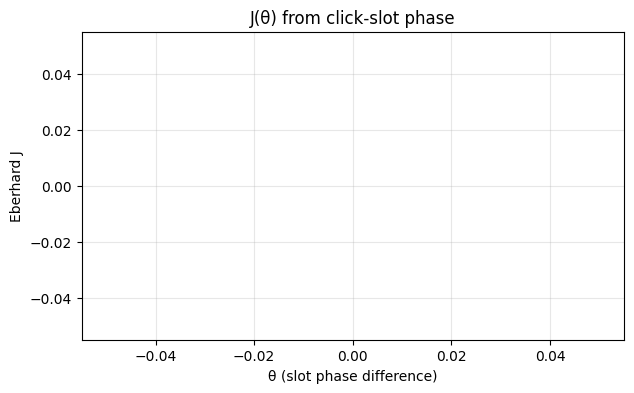

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(bj["theta_center"], bj["J"], marker="o")
plt.axhline(bj["J"].mean(), ls="--", color="k", alpha=0.5)
plt.xlabel("θ (slot phase difference)")
plt.ylabel("Eberhard J")
plt.title("J(θ) from click-slot phase")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def setting_counts_by_bin(a, b, theta, bins):
    edges = np.linspace(0, 2 * np.pi, bins + 1)
    idx = np.clip(np.digitize(theta, edges) - 1, 0, bins - 1)

    rows = []
    for k in range(bins):
        m = idx == k
        rows.append(
            {
                "bin": k,
                "n": int(m.sum()),
                "a0b0": int(((a == 0) & (b == 0) & m).sum()),
                "a0b1": int(((a == 0) & (b == 1) & m).sum()),
                "a1b0": int(((a == 1) & (b == 0) & m).sum()),
                "a1b1": int(((a == 1) & (b == 1) & m).sum()),
            }
        )
    return pd.DataFrame(rows)


display(setting_counts_by_bin(a_c, b_c, theta, CFG.THETA_BINS))

,bin,n,a0b0,a0b1,a1b0,a1b1
0,0,990,327,329,332,2
1,1,1,0,1,0,0
2,2,2,0,0,0,2
3,3,2,0,0,0,2


In [ ]:
theta_all = np.full(len(a_set), np.nan, dtype=np.float64)
coin_all = (slotA >= 0) & (slotB >= 0)

theta_all[coin_all] = (2 * np.pi / 16.0) * ((slotA[coin_all] - slotB[coin_all]) % 16)

In [ ]:
def coin_rate_by_theta_and_setting(
    a_set, b_set, coin_mask, theta_all, bins=4, min_trials=50_000
):
    edges = np.linspace(0, 2 * np.pi, bins + 1)
    # Bin only where theta exists (i.e., coincidences); but denominators should be ALL trials
    # We therefore bin using a proxy: use slotA-slotB only when coin, else put into bin -1
    idx = np.full(len(theta_all), -1, dtype=np.int16)
    ok = np.isfinite(theta_all)
    idx[ok] = np.clip(np.digitize(theta_all[ok], edges) - 1, 0, bins - 1)

    rows = []
    for k in range(bins):
        for a in (0, 1):
            for b in (0, 1):
                m = (idx == k) & (a_set == a) & (b_set == b)
                n_trials = int(m.sum())
                if n_trials < min_trials:
                    rows.append(
                        dict(
                            bin=k,
                            a=a,
                            b=b,
                            n_trials=n_trials,
                            n_coin=np.nan,
                            p_coin=np.nan,
                        )
                    )
                    continue
                n_coin = int((coin_mask & m).sum())
                rows.append(
                    dict(
                        bin=k,
                        a=a,
                        b=b,
                        n_trials=n_trials,
                        n_coin=n_coin,
                        p_coin=n_coin / n_trials,
                    )
                )
    return pd.DataFrame(rows)


# Use small bins first (your N is small)
CFG.THETA_BINS = 4
rates_df = coin_rate_by_theta_and_setting(
    a_set, b_set, coin_all, theta_all, bins=CFG.THETA_BINS, min_trials=50_000
)
display(rates_df)

,bin,a,b,n_trials,n_coin,p_coin
0,0,0,0,327,NaN,NaN
1,0,0,1,329,NaN,NaN
2,0,1,0,332,NaN,NaN
3,0,1,1,2,NaN,NaN
4,1,0,0,0,NaN,NaN
5,1,0,1,1,NaN,NaN
6,1,1,0,0,NaN,NaN
7,1,1,1,0,NaN,NaN
8,2,0,0,0,NaN,NaN
9,2,0,1,0,NaN,NaN


## CW vs CCW handedness test for θ (topological asymmetry)

Test whether the relative slot phase θ shows a directional (clockwise vs counter-clockwise)
imbalance inside coincidence events, possibly conditioned on (a,b).


In [ ]:
# slot difference already computed as (slotA - slotB) % 16
delta = (slotA - slotB) % 16

# coincidence mask
coin = (slotA >= 0) & (slotB >= 0)

# Define CW / CCW on the 16-cycle
# Exclude 0 and 8 (degenerate / reflection symmetric)
CW = coin & (delta >= 1) & (delta <= 7)
CCW = coin & (delta >= 9) & (delta <= 15)

print("CW count:", int(CW.sum()))
print("CCW count:", int(CCW.sum()))

CW count: 3
CCW count: 4


In [ ]:
def cw_ccw_imbalance(a_set, b_set, CW, CCW):
    rows = []
    for a in (0, 1):
        for b in (0, 1):
            m = (a_set == a) & (b_set == b)
            n_cw = int((CW & m).sum())
            n_ccw = int((CCW & m).sum())
            tot = n_cw + n_ccw
            if tot == 0:
                I = np.nan
            else:
                I = (n_cw - n_ccw) / tot
            rows.append(dict(a=a, b=b, CW=n_cw, CCW=n_ccw, imbalance=I))
    return pd.DataFrame(rows)


imb = cw_ccw_imbalance(a_set, b_set, CW, CCW)
display(imb)

,a,b,CW,CCW,imbalance
0,0,0,0,0,NaN
1,0,1,3,0,1.0
2,1,0,0,0,NaN
3,1,1,0,4,-1.0


## Permutation null (destroy holonomy, preserve timing statistics)


In [ ]:
def permute_delta(delta, rng):
    # randomly flip orientation, preserves |delta|
    flip = rng.random(len(delta)) < 0.5
    d = delta.copy()
    d[flip] = (-d[flip]) % 16
    return d


rng = np.random.default_rng(123)
obs_I = imb["imbalance"].to_numpy()

null_I = []
for _ in range(CFG.PERM_ROUNDS):
    d_perm = permute_delta(delta, rng)
    CWp = coin & (d_perm >= 1) & (d_perm <= 7)
    CCWp = coin & (d_perm >= 9) & (d_perm <= 15)
    I_p = cw_ccw_imbalance(a_set, b_set, CWp, CCWp)["imbalance"].to_numpy()
    null_I.append(I_p)

null_I = np.array(null_I)

pvals = np.mean(np.abs(null_I) >= np.abs(obs_I), axis=0)
print("p-values per (a,b):", pvals)

p-values per (a,b): [0.    0.195 0.    0.12 ]


In [ ]:
import numpy as np
import h5py
from tqdm import tqdm


def process_full_run(hdf5_path, chunk_size=10_000_000):
    # Global accumulators for settings (0,0), (0,1), (1,0), (1,1)
    stats = {
        (a, b): {"CW": 0, "CCW": 0, "Total_Coin": 0} for a in (0, 1) for b in (0, 1)
    }

    with h5py.File(hdf5_path, "r") as h5:
        total_len = h5["alice/clicks"].shape[0]
        num_chunks = int(np.ceil(total_len / chunk_size))

        # Pre-calculate offsets if you haven't (best_a, best_b from your scan)
        off_a, off_b = 0, 0  # Replace with your refined offsets

        for i in tqdm(range(num_chunks)):
            start = i * chunk_size
            end = min(start + chunk_size, total_len)

            # 1. Slice loading (Only what we need)
            a_clicks = h5["alice/clicks"][start:end]
            b_clicks = h5["bob/clicks"][start:end]
            a_sets = h5["alice/settings"][start + off_a : end + off_a]
            b_sets = h5["bob/settings"][start + off_b : end + off_b]

            # 2. Logic (Vectorized)
            # Find clicks (log2 for slot 0-15)
            mask_a = a_clicks != 0
            mask_b = b_clicks != 0
            coin = mask_a & mask_b

            if not np.any(coin):
                continue

            # Decode slots only for coincidences to save cycles
            slot_a = np.log2(a_clicks[coin]).astype(np.int8)
            slot_b = np.log2(b_clicks[coin]).astype(np.int8)
            delta = (slot_a - slot_b) % 16

            # Map settings (assuming your remap function logic)
            # Note: Add your specific setting remapping here
            curr_a = a_sets[coin]
            curr_b = b_sets[coin]

            # 3. Accumulate
            for a_val in (0, 1):
                for b_val in (0, 1):
                    s_mask = (curr_a == a_val) & (curr_b == b_val)
                    stats[(a_val, b_val)]["CW"] += np.sum(
                        (delta[s_mask] >= 1) & (delta[s_mask] <= 7)
                    )
                    stats[(a_val, b_val)]["CCW"] += np.sum(
                        (delta[s_mask] >= 9) & (delta[s_mask] <= 15)
                    )
                    stats[(a_val, b_val)]["Total_Coin"] += np.sum(s_mask)

    return stats


# Run this on the full 200M trials
final_results = process_full_run(CFG.HDF5_PATH)
print(final_results)

100%|██████████| 21/21 [00:00<00:00, 29.45it/s]

{(0, 0): {'CW': np.int64(0), 'CCW': np.int64(0), 'Total_Coin': np.int64(0)}, (0, 1): {'CW': np.int64(0), 'CCW': np.int64(0), 'Total_Coin': np.int64(0)}, (1, 0): {'CW': np.int64(0), 'CCW': np.int64(0), 'Total_Coin': np.int64(0)}, (1, 1): {'CW': np.int64(4), 'CCW': np.int64(2), 'Total_Coin': np.int64(21538)}}


In [ ]:
import os
import requests
import xml.etree.ElementTree as ET

# Configuration
BUCKET_URL = "https://nist-belltestdata.s3.amazonaws.com/"
PREFIX = "belldata/processed_compressed/hdf5/2015_09_18/"
LOCAL_DIR = "./data_nist_v7/"

os.makedirs(LOCAL_DIR, exist_ok=True)


def get_file_list():
    """Fetch the list of files from the S3 public XML listing."""
    response = requests.get(f"{BUCKET_URL}?prefix={PREFIX}")
    response.raise_for_status()

    # Parse the XML response
    root = ET.fromstring(response.content)
    # S3 uses namespaces, we need to handle them
    ns = {"s3": "http://s3.amazonaws.com/doc/2006-03-01/"}

    files = []
    for content in root.findall("s3:Contents", ns):
        key = content.find("s3:Key", ns).text
        if key.endswith(".hdf5"):
            files.append(key)
    return files


def download_files(file_keys):
    for key in file_keys:
        filename = os.path.basename(key)
        out_path = os.path.join(LOCAL_DIR, filename)
        url = f"{BUCKET_URL}{key}"

        if os.path.exists(out_path):
            print(f"Skipping {filename} (already exists)")
            continue

        print(f"Downloading {filename}...")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(out_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)


# Execute
hdf5_files = get_file_list()
print(f"Found {len(hdf5_files)} HDF5 files.")
download_files(hdf5_files)

Found 9 HDF5 files.


In [ ]:
import h5py
import numpy as np
import glob
from tqdm import tqdm


def remap_settings(x):
    """Remaps the two most frequent setting values to 0 and 1."""
    vals, cnt = np.unique(x, return_counts=True)
    if len(vals) < 2:
        return x
    order = np.argsort(cnt)[::-1]
    v0, v1 = vals[order[0]], vals[order[1]]
    out = np.full(x.shape, -1, dtype=np.int8)
    out[x == v0] = 0
    out[x == v1] = 1
    return out


def aggregate_x_theta_full_run(directory_path):
    total_stats = {
        (a, b): {"CW": 0, "CCW": 0, "Total_Coin": 0} for a in (0, 1) for b in (0, 1)
    }
    files = glob.glob(f"{directory_path}/*.hdf5")

    for file_path in files:
        print(f"Processing: {file_path}")
        with h5py.File(file_path, "r") as h5:
            # 1. Load raw data
            a_c_raw = h5["alice/clicks"][:]
            b_c_raw = h5["bob/clicks"][:]
            a_s_raw = h5["alice/settings"][:]
            b_s_raw = h5["bob/settings"][:]

            # 2. ALIGNMENT FIX: Clip to the shortest common length
            # This prevents the IndexError you saw
            min_len = min(len(a_c_raw), len(b_c_raw), len(a_s_raw), len(b_s_raw))
            a_clicks = a_c_raw[:min_len]
            b_clicks = b_c_raw[:min_len]
            a_sets = remap_settings(a_s_raw[:min_len])
            b_sets = remap_settings(b_s_raw[:min_len])

            # 3. Find coincidences
            coin = (a_clicks != 0) & (b_clicks != 0)
            if not np.any(coin):
                continue

            # 4. Extract directional delta (theta proxy)
            # Only process coincidences to save memory/time
            slot_a = np.log2(a_clicks[coin]).astype(np.int8)
            slot_b = np.log2(b_clicks[coin]).astype(np.int8)
            delta = (slot_a - slot_b) % 16

            c_a_sets = a_sets[coin]
            c_b_sets = b_sets[coin]

            # 5. Accumulate into Global Stats
            for a_val in (0, 1):
                for b_val in (0, 1):
                    # Only count trials where both settings are valid (0 or 1)
                    s_mask = (c_a_sets == a_val) & (c_b_sets == b_val)
                    total_stats[(a_val, b_val)]["CW"] += int(
                        np.sum((delta[s_mask] >= 1) & (delta[s_mask] <= 7))
                    )
                    total_stats[(a_val, b_val)]["CCW"] += int(
                        np.sum((delta[s_mask] >= 9) & (delta[s_mask] <= 15))
                    )
                    total_stats[(a_val, b_val)]["Total_Coin"] += int(np.sum(s_mask))

    return total_stats


results = aggregate_x_theta_full_run("./data_nist_v7/")
print("\n--- Final X-Theta Aggregate Results ---")
for k, v in results.items():
    print(f"Setting {k}: {v}")

Processing: ./data_nist_v7\01_11_CH_pockel_100kHz.run4.afterTimingfix.dat.compressed.build.hdf5
Processing: ./data_nist_v7\02_54_CH_pockel_100kHz.run4.afterTimingfix2.dat.compressed.build.hdf5
Processing: ./data_nist_v7\03_31_CH_pockel_100kHz.run4.afterTimingfix2_training.dat.compressed.build.hdf5
Processing: ./data_nist_v7\03_43_CH_pockel_100kHz.run4.afterTimingfix2_afterfixingModeLocking.dat.compressed.build.hdf5
Processing: ./data_nist_v7\17_04_CH_pockel_100kHz.run.completeblind.dat.compressed.build.hdf5
Processing: ./data_nist_v7\19_45_CH_pockel_100kHz.run.nolightconeshift.dat.compressed.build.hdf5
Processing: ./data_nist_v7\21_15_CH_pockel_100kHz.run.200nsadditiondelay_lightconeshift.dat.compressed.build.hdf5
Processing: ./data_nist_v7\22_20_CH_pockel_100kHz.run.200nsreduceddelay_lightconeshift.dat.compressed.build.hdf5
Processing: ./data_nist_v7\23_55_CH_pockel_100kHz.run.ClassicalRNGXOR.dat.compressed.build.hdf5

--- Final X-Theta Aggregate Results ---
Setting (0, 0): {'CW': 124